# imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix

# load data

In [3]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# define X (features) and y (target)

In [4]:
X = data.drop(columns=["SalePrice", "Id"])
y = data["SalePrice"]

# train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# build preprocessing pipeline

In [6]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# build linear regression pipeline

In [7]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

# train the model

In [8]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# show the most important features to predicting price

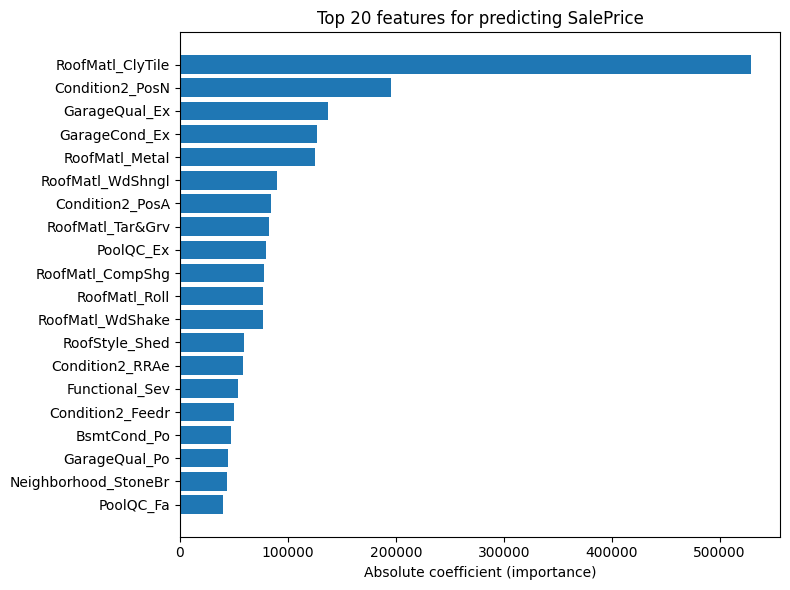

In [9]:
# Get the trained preprocessor and linear regression model from the pipeline
preprocessor = model.named_steps["preprocessor"]
lin_reg = model.named_steps["classifier"]

# Get the feature names after preprocessing (includes one-hot encoded columns)
feature_names = preprocessor.get_feature_names_out()

# Coefficients learned by LinearRegression (one per feature)
coefs = lin_reg.coef_

# Put them in a DataFrame and sort by absolute size (bigger = more important)
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "importance": np.abs(coefs)
}).sort_values(by="importance", ascending=False)


feature_importance["pretty_feature"] = (
    feature_importance["feature"]
      .str.replace("^num__", "", regex=True)
      .str.replace("^cat__", "", regex=True)
)

# Show the top 20 most important features
import matplotlib.pyplot as plt

# Take the top 20 features and sort them from least to most important for nicer plotting
top_n = 20
top_features = feature_importance.head(top_n).sort_values("importance")

plt.figure(figsize=(8, 6))
plt.barh(top_features["pretty_feature"], top_features["importance"])
plt.xlabel("Absolute coefficient (importance)")
plt.title(f"Top {top_n} features for predicting SalePrice")
plt.tight_layout()
plt.show()

## Feature Selection with ANOVA F-test (SelectKBest)

Here we select the top-k features (after preprocessing) using an ANOVA F-test
for regression (`f_regression`), then train a Linear Regression model on only
those features.

In [10]:
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection with ANOVA F-test (for regression)
k = 25  # number of best features to keep after preprocessing

anova_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_select", SelectKBest(score_func=f_regression, k=k)),
    ("regressor", LinearRegression())
])

# Train the model using only the selected features
anova_model.fit(X_train, y_train)

# Evaluate on test data
y_pred_anova = anova_model.predict(X_test)
r2_anova = anova_model.score(X_test, y_test)
print(f"R^2 score using SelectKBest (ANOVA F-test) with top {k} features: {r2_anova:.4f}")

# (Optional) See which features were selected after preprocessing
preprocessed_feature_names = preprocessor.get_feature_names_out()
mask = anova_model.named_steps["feature_select"].get_support()
selected_features = preprocessed_feature_names[mask]

print("Selected features (ANOVA):")
for f in selected_features:
    print(" -", f)

R^2 score using SelectKBest (ANOVA F-test) with top 25 features: 0.8408
Selected features (ANOVA):
 - num__OverallQual
 - num__YearBuilt
 - num__YearRemodAdd
 - num__MasVnrArea
 - num__TotalBsmtSF
 - num__1stFlrSF
 - num__GrLivArea
 - num__FullBath
 - num__TotRmsAbvGrd
 - num__Fireplaces
 - num__GarageYrBlt
 - num__GarageCars
 - num__GarageArea
 - cat__ExterQual_Ex
 - cat__ExterQual_Gd
 - cat__ExterQual_TA
 - cat__Foundation_PConc
 - cat__BsmtQual_Ex
 - cat__BsmtQual_TA
 - cat__BsmtFinType1_GLQ
 - cat__HeatingQC_Ex
 - cat__KitchenQual_Ex
 - cat__KitchenQual_TA
 - cat__GarageFinish_Fin
 - cat__GarageFinish_Unf


## Feature Extraction with PCA

Here we apply PCA after preprocessing to reduce the data to a smaller number
of principal components, then train a Linear Regression model on those
components.

In [11]:
from sklearn.decomposition import PCA

# Feature extraction with PCA (dimensionality reduction)
n_components = 25  # number of principal components to keep

pca_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=n_components, random_state=42)),
    ("regressor", LinearRegression())
])

# Train the model using PCA-transformed features
pca_model.fit(X_train, y_train)

# Evaluate on test data
y_pred_pca = pca_model.predict(X_test)
r2_pca = pca_model.score(X_test, y_test)
print(f"R^2 score using PCA with {n_components} components: {r2_pca:.4f}")

# (Optional) how much variance the components explain
pca_step = pca_model.named_steps["pca"]
explained = pca_step.explained_variance_ratio_.sum()
print(f"Total variance explained by {n_components} components: {explained:.2%}")

R^2 score using PCA with 25 components: 0.8248
Total variance explained by 25 components: 76.26%


# predict on the test data

In [12]:
y_pred_price = model.predict(X_test)

# Take a look at a few predictions vs actual
pd.DataFrame({
    "ActualPrice": y_test.values[:10],
    "PredictedPrice": y_pred_price[:10]
})

,ActualPrice,PredictedPrice
0,154500,157608.317437
1,325000,348503.243670
2,115000,86479.084505
3,159000,174161.874099
4,315500,316990.834179
5,75500,66783.965891
6,311500,236151.684009
7,146000,146004.697701
8,84500,57564.871229
9,135500,154052.104807


# compare models

In [13]:
# Compare performance of all three models

scores = {
    "Original Linear Regression": model.score(X_test, y_test),
    "ANOVA SelectKBest": anova_model.score(X_test, y_test),
    "PCA": pca_model.score(X_test, y_test)
}

comparison_df = (
    pd.DataFrame(scores.items(), columns=["Model", "R2 Score"])
      .sort_values("R2 Score", ascending=False)
      .reset_index(drop=True)
)

comparison_df

,Model,R2 Score
0,Original Linear Regression,0.886744
1,ANOVA SelectKBest,0.840839
2,PCA,0.824772


# classify prices

In [14]:
# Use the training prices to define cut points (bins)
price_bins_labels = ["low", "medium", "high"]

# qcut will split y_train into 3 groups with roughly equal size
y_train_bins, price_bins_edges = pd.qcut(
    y_train,
    q=3,
    labels=price_bins_labels,
    retbins=True,
    duplicates="drop"  # in case of ties
)

y_train_bins.head()

254     medium
1066    medium
638        low
799     medium
380        low
Name: SalePrice, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [15]:
# Convert true test prices into low/medium/high
# Clip test values to be within the bin range
y_test_clipped = np.clip(y_test.values, price_bins_edges[0], price_bins_edges[-1])
y_test_cat = pd.cut(
    y_test_clipped,
    bins=price_bins_edges,
    labels=price_bins_labels,
    include_lowest=True
)

# Convert predicted prices into low/medium/high
# Clip predictions to be within the bin range to avoid NaN values
y_pred_clipped = np.clip(y_pred_price, price_bins_edges[0], price_bins_edges[-1])
y_pred_cat = pd.cut(
    y_pred_clipped,
    bins=price_bins_edges,
    labels=price_bins_labels,
    include_lowest=True
)

print(y_test_cat[:5])
print("-----")
print(y_pred_cat[:5])

['medium', 'high', 'low', 'medium', 'high']
Categories (3, object): ['low' < 'medium' < 'high']
-----
['medium', 'high', 'low', 'medium', 'high']
Categories (3, object): ['low' < 'medium' < 'high']


# evaluate the model

              precision    recall  f1-score   support

        high       0.87      0.98      0.92        94
         low       0.87      0.83      0.85       115
      medium       0.73      0.67      0.70        83

    accuracy                           0.83       292
   macro avg       0.82      0.83      0.82       292
weighted avg       0.83      0.83      0.83       292



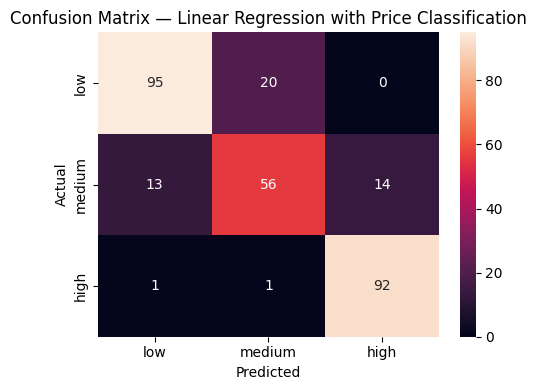

In [16]:
print(classification_report(y_test_cat, y_pred_cat))

cm = confusion_matrix(y_test_cat, y_pred_cat, labels=price_bins_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_bins_labels,
    yticklabels=price_bins_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Linear Regression with Price Classification")
plt.tight_layout()
plt.show()